In [ ]:
# Matthew McFee
# DAT112 - Assignment #3

# Import libraries
import pandas as pd
import numpy as np
import tensorflow

# Importing the data 

# Use wget to fetch the data from the source 
print("Reading the ChEMB data.")
!pip install wget
!wget "https://support.scinet.utoronto.ca/~ejspence/chembl.csv.gz"

# Extract
!gunzip "chembl.csv.gz" 

Reading the ChEMB data.
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=62148f69a2ada968bb15c30389361acc5eca86728431acc02ae540e0648e3eef
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
--2020-08-03 22:49:31--  https://support.scinet.utoronto.ca/~ejspence/chembl.csv.gz
Resolving support.scinet.utoronto.ca (support.scinet.utoronto.ca)... 142.150.255.98
Connecting to support.scinet.utoronto.ca (support.scinet.utoronto.ca)|142.150.255.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115390444 (110M) [application/x-gzip]
Saving to: ‘chembl.csv.gz’

chembl.csv.gz       100%[===================>] 110.04M  45.1MB/s    in 2.4s    

2020-08-03 22:49:34 (45.1 MB/s) - ‘chembl.csv.gz’ saved [115390444/115390444]



In [ ]:
df = pd.read_csv("chembl.csv")
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Molecule.ChEMBL.ID,Molecule.Name,Molecule.Max.Phase,Molecular.Weight,X.RO5.Violations,AlogP,Compound.Key,Smiles,Standard.Type,Standard.Relation,Standard.Value,Standard.Units,pChEMBL.Value,Data.Validity.Comment,Comment,Uo.Units,Ligand.Efficiency.BEI,Ligand.Efficiency.LE,Ligand.Efficiency.LLE,Ligand.Efficiency.SEI,Potential.Duplicate,Assay.ChEMBL.ID,Assay.Description,Assay.Type,BAO.Format.ID,BAO.Label,Assay.Organism,Assay.Tissue.ChEMBL.ID,Assay.Tissue.Name,Assay.Cell.Type,Assay.Subcellular.Fraction,Target.ChEMBL.ID,Target.Name,Target.Organism,Target.Type,Document.ChEMBL.ID,Source.ID,Source.Description,Document.Journal,Document.Year,Cell.ChEMBL.ID
0,1,CHEMBL128540,NaN,0,453.93,0,3.52,44,CC(=O)Oc1cc(S(=O)(=O)Nc2n[nH]c(Nc3ccc(C)cc3)n2...,IC50,'=',10000.00,nM,5.00,NaN,NaN,UO_0000065,11.01,0.24,1.48,3.97,False,CHEMBL701803,Inhibitory activity against DNA strand transfe...,B,BAO_0000357,single protein format,Human immunodeficiency virus 1,None,None,None,None,CHEMBL3471,Human immunodeficiency virus type 1 integrase,Human immunodeficiency virus 1,SINGLE PROTEIN,CHEMBL1148381,1,Scientific Literature,J. Med. Chem.,2004.0,None
1,2,CHEMBL197988,NaN,0,486.17,0,4.83,5,O=C1N[C@H](c2c[nH]c3cc(Br)ccc23)CN=C1c1c[nH]c2...,IC50,'=',86.34,ug.mL-1,NaN,Outside typical range,NaN,UO_0000274,NaN,NaN,NaN,NaN,False,CHEMBL881409,Inhibitory activity against Sortase A from Sta...,B,BAO_0000357,single protein format,Staphylococcus aureus,None,None,None,None,CHEMBL5362,Sortase A,Staphylococcus aureus,SINGLE PROTEIN,CHEMBL1143488,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,None
2,3,CHEMBL1518799,NaN,0,264.24,0,1.65,SID17516664,CCOC(=O)/C=C/C(=O)Nc1cccc([N+](=O)[O-])c1,IC50,'=',7030.00,nM,5.15,NaN,Active,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1737860,PUBCHEM_BIOASSAY: Dose Response confirmation o...,F,BAO_0000019,assay format,Saccharomyces cerevisiae S288c,None,None,None,None,CHEMBL1741194,Mitochondrial import inner membrane translocas...,Saccharomyces cerevisiae S288c,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None
3,4,CHEMBL371047,NaN,0,238.24,0,2.85,6d,O=C1Oc2ccccc2/C1=C\c1ccc(O)cc1,IC50,'=',10100.00,nM,5.00,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL856240,Cytotoxic activity against human non-small lun...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,NCI-H460,None,CHEMBL396,NCI-H460,Homo sapiens,CELL-LINE,CHEMBL1141060,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,CHEMBL3307677
4,5,CHEMBL198389,NaN,0,566.63,1,4.55,15,COc1c(CO)ccc2oc(C(=O)Nc3ccc(-c4ccc(S(=O)(=O)N[...,IC50,NaN,NaN,NaN,NaN,NaN,Not Determined,NaN,NaN,NaN,NaN,NaN,False,CHEMBL881389,Inhibitory concentration against MMP-8; - = no...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,CHEMBL4588,Matrix metalloproteinase 8,Homo sapiens,SINGLE PROTEIN,CHEMBL1143494,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,None


In [ ]:
# Store the SMILES column and the target column in a new data frame
df = df[["Smiles", "AlogP"]]
df.head()

,Smiles,AlogP
0,CC(=O)Oc1cc(S(=O)(=O)Nc2n[nH]c(Nc3ccc(C)cc3)n2...,3.52
1,O=C1N[C@H](c2c[nH]c3cc(Br)ccc23)CN=C1c1c[nH]c2...,4.83
2,CCOC(=O)/C=C/C(=O)Nc1cccc([N+](=O)[O-])c1,1.65
3,O=C1Oc2ccccc2/C1=C\c1ccc(O)cc1,2.85
4,COc1c(CO)ccc2oc(C(=O)Nc3ccc(-c4ccc(S(=O)(=O)N[...,4.55


In [ ]:
df = df[0:50000]
print(df.shape)

(50000, 2)


In [ ]:
# Get rdkit so we can look at molecules
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-08-03 22:49:46--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-08-03 22:49:46--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   189MB/s    in 0.4s    

2020-08-03 22:49:47 (189 MB/s) - ‘Minicon

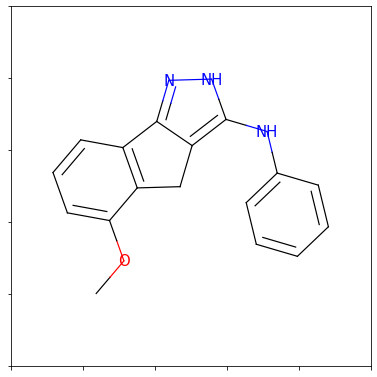

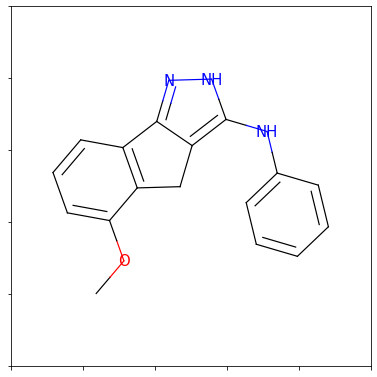

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

smiles = df.iloc[666, 0]
chem = Chem.MolFromSmiles(smiles)
Draw.MolToMPL(chem, size = (200, 200))
# plt.show()

In [ ]:
# Preprocess the data

def build_encoder_decoder(data):
  #charset= sorted(list(set(df.iloc[:,0].values)))
  charset = set(set(data.iloc[:,0].values.sum()))
  char_to_int = dict((c,i) for i,c in enumerate(charset))
  int_to_char = dict((i,c) for i,c in enumerate(charset))

  return charset, char_to_int, int_to_char

charset, char_to_int, int_to_char = build_encoder_decoder(df)

# print(len(char_to_int))
# print(char_to_int)

X = df.iloc[:,0].values

# print(X[1])

def preprocess_data(encoder, X):

  max_len = 0

  for i, smile_value in enumerate(X):
    if len(smile_value) > max_len:
      max_len = len(smile_value)
  
  X_processed = []

  for i, smile_value in enumerate(X):

      smile_encoded = [encoder[symbol]/(len(charset)+1) for symbol in smile_value] + [len(charset)+1]*(max_len - len(smile_value))
      #smile_str = [str(element) for element in smile_list]
      #res = "".join(smile_str)
      #X_processed.append(int(res))
      X_processed.append(smile_encoded)

  return X_processed  

X_processed = preprocess_data(char_to_int, X)

In [ ]:
X_processed = np.asarray(X_processed)
print(X_processed.shape)

X_processed = X_processed.reshape(50000, 243, 1)

(50000, 243)


In [ ]:
from sklearn.model_selection import train_test_split

y = df.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3,
                                                    random_state=666)

In [ ]:
# Define a function to build a network
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
# No matter what architecture I try the accuracy never changes

def build_network():
  print("Building network.")
  model = Sequential()
  model.add(LSTM(128, input_shape=(X_processed.shape[1], X_processed.shape[2]), 
                 return_sequences=True))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  
  model.compile(optimizer="adam", loss="MSE")

  return model

model = build_network()

Building network.


In [ ]:
# Train the network
def train_network(model, X_train, y_train, batch_size=200, epochs=200):
  print("Training network.")
  history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
  
  return history, model

history, model = train_network(model, X_train, y_train)

Training network.
Epoch 1/200
175/175 [==============================] - 3s 20ms/step - loss: 4.3118
Epoch 2/200
175/175 [==============================] - 3s 20ms/step - loss: 3.8768
Epoch 3/200
175/175 [==============================] - 3s 19ms/step - loss: 3.8001
Epoch 4/200
175/175 [==============================] - 3s 20ms/step - loss: 3.6880
Epoch 5/200
175/175 [==============================] - 3s 19ms/step - loss: 3.5346
Epoch 6/200
175/175 [==============================] - 3s 20ms/step - loss: 3.5140
Epoch 7/200
175/175 [==============================] - 3s 20ms/step - loss: 3.4912
Epoch 8/200
175/175 [==============================] - 3s 20ms/step - loss: 3.4748
Epoch 9/200
175/175 [==============================] - 3s 19ms/step - loss: 3.4643
Epoch 10/200
175/175 [==============================] - 3s 20ms/step - loss: 3.4578
Epoch 11/200
175/175 [==============================] - 3s 20ms/step - loss: 3.4558
Epoch 12/200
175/175 [==============================] - 3s 19ms/ste

In [ ]:
print("The training set performance is: ", history.history["loss"][-1])
print("The test set performance is: ", model.evaluate(X_test, y_test, verbose=0))

The training set performance is:  0.7138413786888123
The test set performance is:  0.8634568452835083
